In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import jax
from scipy.stats import beta
from jax.scipy.special import beta as beta_fun
from jax.scipy.special import digamma
from numpy.random import multivariate_normal as mvn
import matplotlib.pyplot as plt
from matplotlib import cm

##**GENERAZIONE DATI**

This is the model for cluster paramters (so a sort of $G_0$):
\begin{align*}
  \mu_k & \stackrel{\tiny\mbox{iid}}{\sim} \mathcal{N}_d\left(\mu_0,\ \sigma^2 \mathbb{I}_d\right) & k=1,...,K \\
\end{align*}
with K the number of clusters, not known a priori, defined during data generation
We will generalize then by assuming a prior over $\sigma^2$ that could be for example the implementation of a NNIG model in a DP mixture

Data model:
\begin{align*}
  X_i|\eta,z_i \stackrel{\tiny\mbox{und}}{\sim} \mathcal{N}_d\left(\mu_{z_i},\ \mathbb{I}_d\right) \quad \quad i=1,...,N
\end{align*}
with $\eta$ such that $\eta_k$ is equal to the mean and varianc for each cluster $k=1,....,K$

So the final DP mixture model is:
\begin{align*}
  X_i|\mu_i &\stackrel{\tiny\mbox{ind}}{\sim} \mathcal{N}_d\left(\mu_{z_i},\ \mathbb{I}_d\right) &i=1,...,N \\
  \mu_i|P &\stackrel{\tiny\mbox{iid}}{\sim} P \\
  P &\sim \mathcal{D}_{\alpha} & \\
  \alpha &= \mathcal{N}_d\left(0_d,\ \sigma^2\mathbb{I}_d\right)
\end{align*}

DA METTERE A POSTO, NEL PAPER C'E' LA DISTRIBUZIONE DI $x_n$ CONDIZIONATA \\
SEGUE FAMIGLIA ESPONENZIALE

1.0


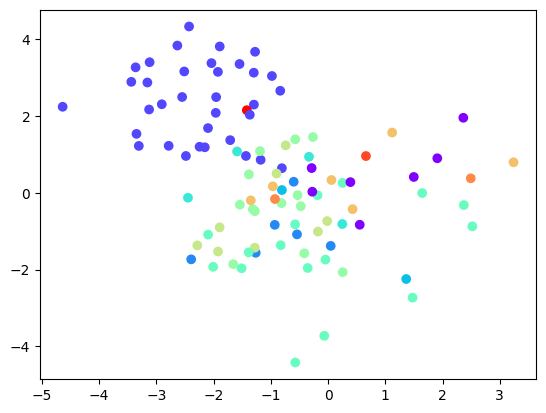

Final number of clusters:  12


In [ ]:
seed=2023
np.random.seed(seed)

# Instantiate the first topic
alpha = 5
n = 100
d = 2

assignment = [0] # first point must be assigned to first cluster
rho_1 = beta(1, alpha).rvs()
remainder = 1-rho_1
rhos = [remainder, rho_1]
new_or_existk = [-1, 0]
ntopics =1
mu0 = np.zeros(d)
sigma2=1
Id=np.eye(d)
#sigma0 = np.identity(d)

#cov1 = invwishart(df=2, scale=sigma0).rvs()
mu1 = mvn(mu0, sigma2*Id)

mus = [mu1]
#covs = [cov1]

for i in range(1, n):
  k = np.random.choice(new_or_existk, p=rhos)
  if k==-1:
    # generate new topic
    new_rho = beta(1, alpha).rvs() * remainder
    remainder -= new_rho
    rhos[0] = remainder
    rhos.append(new_rho)

    ntopics += 1
    assignment.append(ntopics-1) #zero-based indexing
    new_or_existk.append(ntopics-1)
    # generation of new cluster parameters
    # choose a distribution G_0 for the cluster parameters, then a distribution for data given the cluster parameters
    #new_cov = invwishart(df=d, scale=sigma0).rvs()
    new_mu = mvn(mean=mu0, cov=sigma2*Id)
    mus.append(new_mu)
    #covs.append(new_cov)
  else:
    assignment.append(k)

rhos=rhos/np.sum(rhos)

print(np.sum(rhos))

# data generation
datapoints = []
colors = cm.rainbow(np.linspace(0, 1, ntopics))
cs = []

for i in assignment:
  x = mvn(mean=mus[i], cov=Id)
  datapoints.append(x)
  cs.append(colors[i])

xs = [d[0] for d in datapoints]
ys = [d[1] for d in datapoints]
datapoints=jnp.array(datapoints)

plt.scatter(xs, ys, color=cs)
plt.show()
print('Final number of clusters: ',len(mus))

## CAVI FOR DP MIXTURE

In [ ]:
'''
def update_phi(data,gamma,tau1,tau2):
  # a è la funzione proposta da noi della distribuzione esponenziale di eta*
  # grad_a=jit(jax.grad(a))
  # sum_terms2=jnp.zeros(T)
  N=data.shape[0]
  T=tau1.shape[0]

  def true_fun(state):
    t,x,gamma,sum_terms2=state
    term2=digamma(gamma[t-1,1])-digamma(gamma[t-1,0]+gamma[t-1,1])
    sum_terms2.at[t].set(sum_terms2[t-1]+term2)
    return sum_terms2

  def false_fun(state):
    _,_,_,sum_terms2=state
    return sum_terms2

  updated_phi=jnp.zeros((N,T))
  log_likelihood=jnp.zeros((N,T))
  sum_terms2=jnp.zeros(T)
  for t in jnp.arange(T):
    term1=digamma(gamma[t,0])-digamma(gamma[t,0]+gamma[t,1])
    state=(t,x,gamma,sum_terms2)
    sum_terms2=jax.lax.cond(state[0]>0,true_fun,false_fun,state)
    for n in jnp.arange(N):
      log_likelihood.at[n,t].add(term1 + sum_terms2[t] + tau1[t,:] @ data[n,:].T - 0.5* (tau2[t,0] + tau1[t,:] @ tau1[t,:].T))

  updated_phi = jnp.nan_to_num(jnp.exp(log_likelihood),nan=10**-10,posinf=10**5) + 10**-10 # to avoid round zeros that make the ELBO go nan
  updated_phi /= jnp.sum(updated_phi,axis=1,keepdims=True)
  # update_phi=jax.nn.softmax(log_likelihood,axis=1)
'''
def update_phi(data, gamma, tau1, tau2):
    N = data.shape[0]
    T = tau1.shape[0]

    def true_fun(state):
        t, x, gamma, sum_terms2 = state
        term2=digamma(gamma[t-1,1])-digamma(gamma[t-1,0]+gamma[t-1,1])
        sum_terms2.at[t].set(sum_terms2[t-1]+term2)
        return sum_terms2

    def false_fun(state):
        _, _, _, sum_terms2 = state
        return sum_terms2

    updated_phi = jnp.zeros((N, T))
    log_likelihood = jnp.zeros((N, T))
    sum_terms2 = jnp.zeros(T)

    t_values = jnp.arange(T)
    n_values = jnp.arange(N)

    def update_log_likelihood(t):
        term1 = digamma(gamma[t, 0]) - digamma(gamma[t, 0] + gamma[t, 1])
        state = (t, x, gamma, sum_terms2)
        sum_terms2 = jax.lax.cond(t > 0, true_fun, false_fun, state)
        return term1 + sum_terms2 + tau1[t, :] @ data[n_values, :].T - 0.5 * (tau2[t, 0] + tau1[t, :] @ tau1[t, :].T)

    log_likelihood = jax.vmap(update_log_likelihood)(t_values)
    updated_phi = jnp.nan_to_num(jnp.exp(log_likelihood), nan=10**-10, posinf=10**5) + 10**-10
    updated_phi /= jnp.sum(updated_phi, axis=1, keepdims=True)

    return updated_phi

  ''' IF WE NEED TO COMPUTE log(phi) THEN UNCOMMENT THIS SECTION
  def true_fun(updated_phi):
    updated_phi +=10**-10
    updated_phi /= jnp.sum(updated_phi,axis=1,keepdims=True)
    return updated_phi

  def false_fun(updated_phi):
    return updated_phi

  updated_phi=jax.lax.cond((jnp.sum(updated_phi==0)>0), true_fun, false_fun,updated_phi)
  '''


update_phi_jit=jit(update_phi)
'''
def update_gamma(alpha,phi,T):
  gamma=jnp.ones((T-1,2))
  gamma.at[:,0].set(1+jnp.sum(phi[:,:(T-1)],axis=0)) # ultima riga di phi non ci deve essere
  for t in range(T-1):
    gamma.at[:,1].set(alpha+jnp.sum(jnp.sum(phi[:,t+1:],axis=1),axis=0))
  return gamma
'''

def update_gamma(alpha, phi, T):
  gamma = jnp.ones((T - 1, 2))
  gamma.at[:,0].set(1+jnp.sum(phi[:,:(T-1)],axis=0))
  phi_sum = jnp.sum(phi[:, 1:], axis=1)
  cumulative_phi_sum = jnp.sum(phi_sum,axis=0)
  gamma[:, 1] = alpha + cumulative_phi_sum
  return gamma

update_gamma_jit=jit(update_gamma)

def update_tau(data,phi,sigma):
  tau1=jnp.matmul(phi.T,data)
  tau2=sigma+jnp.sum(phi,axis=0)
  return tau1,tau2

update_tau_jit=jit(update_tau)

def compute_ELBO(data,gamma,tau1,tau2,phi,alpha,sigma):
  N=data.shape[0]
  T=phi.shape[1]

  T1 = (alpha-1)*jnp.sum(digamma(gamma[:,1]) - digamma(gamma[:,0]+gamma[:,1]))

  T2 = -0.5/sigma2*jnp.sum(tau2 + jnp.resize(jnp.diag(tau1 @ tau1.T),(T,1)))

  phi_inverse=phi[:,::-1]
  cum_sum_inv=jnp.cumsum(phi_inverse,axis=1)
  cum_sum_inv_inv=cum_sum_inv[:,::-1]

  T3 = jnp.sum(cum_sum_inv_inv[:,1:]*(digamma(gamma[:(T-1),1])-digamma(gamma[:(T-1),0]+gamma[:(T-1),1]))) + jnp.sum(phi[:,:(T-1)]*(digamma(gamma[:,1]) - digamma(gamma[:,0]+gamma[:,1])))

  T4 = - 0.5*(jnp.sum(phi.T @ (jnp.resize(jnp.diag(data @ data.T), (N,1))) - 2*jnp.diag((phi.T @ data) @ tau1.T)) + jnp.sum(phi @ tau2 + phi @ (jnp.resize(jnp.diag(tau1 @ tau1.T),(T,1)))))

  T5 = -d/2*jnp.sum(jnp.log(tau2))
  T5 += jnp.sum(-jnp.log(beta_fun(gamma[:,0],gamma[:,1])) + (gamma[:,0]-1) @ (digamma(gamma[:,0]) - digamma(gamma[:,0]+gamma[:,1])) + (gamma[:,1]-1) @ (digamma(gamma[:,1]) - digamma(gamma[:,0]+gamma[:,1])))
  T5 += jnp.sum(jnp.log(phi)*phi)


  return T1+T2+T3+T4-T5

compute_ELBO_jit=jit(compute_ELBO)

In [ ]:
def single_iteration_VI(data,T,i,nMax,tol,sigma,alpha):
  # initialize the parameters
  N=data.shape[0]
  d=data.shape[1]
  key = random.PRNGKey(i*seed)
  phi=random.uniform(key,minval=0,maxval=1,shape=(N,T))
  phi/=jnp.sum(phi,axis=1,keepdims=True)
  tau1=random.normal(key,shape=(T,d))
  tau2=random.normal(key,shape=(T,1))
  gamma=jnp.array(random.geometric(key,0.25,(T-1,2)), dtype=float)
  improvement=1
  ELBO_new=compute_ELBO_jit(data,gamma,tau1,tau2,phi,alpha,sigma)
  ELBO_old=ELBO_new-1
  nit=0

  def cond(state):
    _,_,_,_,_,nit,ELBO,improvement,tol,nMax=state
    return (((improvement>tol) & (nit<nMax)) | (ELBO==jnp.nan))

  def iteration_while(state):
    data,gamma,tau1,tau2,phi,nit,ELBO_new,improvement,tol,nMax=state
    phi=update_phi_jit(data,gamma,tau1,tau2)
    gamma=update_gamma(alpha,phi,T)
    tau1,tau2=update_tau_jit(data,phi,sigma)
    tau2=jnp.resize(tau2,(T,1))
    ELBO_old=ELBO_new
    ELBO_new=compute_ELBO_jit(data,gamma,tau1,tau2,phi,alpha,sigma)
    improvement=ELBO_new-ELBO_old
    nit+=1
    return (data,gamma,tau1,tau2,phi,nit,ELBO_new,improvement,tol,nMax)

  state=(data,gamma,tau1,tau2,phi,nit,ELBO_new,improvement,tol,nMax)
  _,gamma,tau1,tau2,phi,nit,ELBO_new,_,_,_=jax.lax.while_loop(cond_fun=cond,body_fun=iteration_while,init_val=state)
  tau=[tau1,tau2]

  return  gamma,tau,phi,ELBO_new,nit

single_iteration_VI_jit=jit(single_iteration_VI,static_argnames=['T'])

In [ ]:
def VI(data,T,nMax,n_iniz,tol,sigma,alpha):
  ELBO_max=0
  for i in range(n_iniz):
    gamma,tau,phi,ELBO_new,nit=single_iteration_VI_jit(data,T,i,nMax,tol,sigma,alpha) # we may need to add some hyperparameters like sigma in gaussian case
    if i==0:
      ELBO_max=ELBO_new
      gamma_max=gamma
      tau_max=tau
      phi_max=phi
      n_max=0
    print('Initialization number: ',i+1,'\t ELBO: ',ELBO_new,'\t N_iterations: ',nit)
    print('=================================================\n')
    if ELBO_new>ELBO_max:
      ELBO_max=ELBO_new
      gamma_max=gamma
      tau_max=tau
      phi_max=phi
      n_max=i
  print('Best initialization at ',n_max+1,' \t ELBO: ',ELBO_max,'\n\n')
  return gamma_max,tau_max,phi_max

In [ ]:
def plot_clusters(data, phi):
    # Get the cluster assignments
    cluster_assignments = jnp.argmax(phi, axis=1)

    # Number of clusters
    num_clusters = phi.shape[1]

    # Create a list of colors for plotting
    #colors = plt.colormaps()
    colors=mcp.gen_color(cmap="viridis",n=num_clusters)
    print(colors)

    # Scatter plot each data point with its assigned color
    plt.figure(figsize=(8, 6))
    for cluster in range(num_clusters):
        plt.scatter(data[cluster_assignments == cluster, 0], data[cluster_assignments == cluster, 1], c=colors[cluster], label=f'Cluster {cluster}')

    plt.legend()
    plt.title('Cluster Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

In [ ]:
tol=10**-16
nMax=2
n_iniz=5
T=50
gamma,tau,phi=VI(datapoints,T,nMax,n_iniz,tol,sigma2,alpha)

Initialization number:  1 	 ELBO:  nan 	 N_iterations:  1

Initialization number:  2 	 ELBO:  nan 	 N_iterations:  1

Initialization number:  3 	 ELBO:  nan 	 N_iterations:  1

Initialization number:  4 	 ELBO:  nan 	 N_iterations:  1

Initialization number:  5 	 ELBO:  nan 	 N_iterations:  1

Best initialization at  1  	 ELBO:  nan 




In [ ]:
np.sum(phi<=0)

Array(0, dtype=int32)

In [ ]:
# Eslicitiamo la likehood di muk rispetto ai dati
# abbiamo vettore assignment, da tradurre come matrice in one-hot-encding
n_cluster = np.sum(C, axis = 0)
m_post=1/(1+1/sigma2**2)/np.matmul(n_cluster.reshape((T,1)),np.ones(shape=(1,d)))*np.matmul(C.T,X)
s2_post=1/(1+1/sigma2**2)/n_cluster

plot_clusters(datapoints, phi)

#for i in range(K):
#  plt.scatter(X[c==i,0],X[c==i,1])
#  plt.scatter(m_post[i, 0], m_post[i, 1], marker='x', color='red', s=100, label=f'Mean Cluster {i}')

#plt.show()

## Cluster error

In [ ]:
error_m_s2,error_clust=error_measure(m_post,s2_post,C,m,s2,phi)
error_m_s2,error_clust